In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras import datasets, layers, models
from keras.layers import GlobalAveragePooling2D, TimeDistributed, Dense, LSTM, GRU, Conv2D, MaxPooling2D, Flatten 
from keras.layers import Input, Rescaling, BatchNormalization, Activation, SeparableConv2D, Reshape, SimpleRNN 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
from pathlib import Path
from imutils import paths
import cv2
from matplotlib import pyplot as plt

In [2]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

In [3]:
input_shape =  (224, 224, 3)
batch_size = 4
time_dist = 250

org_path = Path(r"C:\Users\SWQA\Desktop\STAJ\Metamorphose\Videos\1")
class_paths = [Path(r"class08_30_20"), Path(r"classsenay_1"), Path(r"class16_46_57")]

In [22]:
all_labels = [i for i in os.walk(org_path / class_paths[0] / "Train" / "Label")][0][2]

lie_len = len([i for i in all_labels if i.endswith("l.jpeg")])
err_len = len([i for i in all_labels if i.endswith("e.jpeg")])
both_len = len(all_labels) - lie_len - err_len
none_len = len(list(os.walk(org_path / class_paths[0] / "Train"))[0][2]) - len(all_labels)
all_len = lie_len + err_len + both_len + none_len
print(both_len)
print(lie_len)
print(err_len)
print(none_len)
print(all_len)

class_count = 4

0
7750
216
1769
9735


In [23]:
lie_weight = all_len / ((class_count * lie_len) + 0.000001)
err_weight = all_len / ((class_count * err_len) + 0.000001)
both_weight = all_len / ((class_count * both_len) + 0.000001)
none_weight = all_len / ((class_count * none_len) + 0.000001)
print(both_weight)
print(lie_weight)
print(err_weight)
print(none_weight)

9735000000.0
0.31403225805438606
11.267361098070184
1.3757772751023492


In [54]:
def ins_ind(string, char, index):
        return string[:index] + char + string[index:] 

def __data_gen(wtype, iclass):    
    imgs = []    
    lbls = []
    weights = []
    img_dist = []
    lbl_dist = []
    weight_dist = []
    
    bcounter = 0
    
    seed = 0
    for c in wtype:
        seed += ord(c)
    
    np.random.seed(seed)
    shuffled = np.asarray(sorted(list(os.walk(org_path / class_paths[0] / "Train"))[0][2], key=lambda x: len(x)))
    # np.random.shuffle(shuffled)

    #unroll
    for p in shuffled[:time_dist]:
        img = cv2.imread(str(org_path / iclass / wtype / p), cv2.IMREAD_COLOR)
        img = cv2.resize(img, input_shape[:-1])
        
        img_dist.append(img)

        if os.path.isfile(org_path / iclass / wtype / "Label" / shuffled[time_dist]):
            weight_dist.append(both_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'l', shuffled[time_dist].index('.'))):
            weight_dist.append(lie_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'e', shuffled[time_dist].index('.'))):
            weight_dist.append(err_weight)
        else:
            weight_dist.append(none_weight)

    if os.path.isfile(org_path / iclass / wtype / "Label" / shuffled[time_dist]):
        lbl_dist.append([1, 1])
    elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'l', shuffled[time_dist].index('.'))):
        lbl_dist.append([1, 0])
    elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'e', shuffled[time_dist].index('.'))):
        lbl_dist.append([0, 1])
    else:
        lbl_dist.append([0, 0])


    imgs.append(np.asarray(img_dist, dtype=np.uint8))
    lbls.append(np.asarray(lbl_dist, dtype=np.uint8))
    weights.append(np.asarray(weight_dist, dtype=np.float32))

    bcounter += 1

    for p in range(time_dist, len(shuffled) - 1):
        img_index = shuffled[p]
        lbl_index = shuffled[p + 1]

        img = cv2.imread(str(org_path / iclass / wtype / img_index), cv2.IMREAD_COLOR)
        img = cv2.resize(img, input_shape[:-1])

        img_dist.append(img)
        del img_dist[0]

        if os.path.isfile(org_path / iclass / wtype / "Label" / shuffled[time_dist]):
            lbl_dist.append([1, 1])
            weight_dist.append(both_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'l', shuffled[time_dist].index('.'))):
            lbl_dist.append([1, 0])
            weight_dist.append(lie_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'e', shuffled[time_dist].index('.'))):
            lbl_dist.append([0, 1])
            weight_dist.append(err_weight)
        else:
            lbl_dist.append([0, 0])
            weight_dist.append(none_weight)
        del lbl_dist[0]
        del weight_dist[0]

        imgs.append(np.asarray(img_dist, dtype=np.uint8))
        lbls.append(np.asarray(lbl_dist, dtype=np.uint8))
        weights.append(np.asarray(weight_dist, dtype=np.float32))

        bcounter += 1

        if bcounter % batch_size == 0:
            bcounter = 0
            yield (np.asarray(imgs, dtype=np.uint8), np.asarray(lbls, dtype=np.uint8), np.asarray(weights, dtype=np.float32))
            imgs = []
            lbls = []
            weights = []

def load_data():
    signature = (tf.TensorSpec(shape=(batch_size, time_dist, *input_shape), dtype=tf.uint8),
                 tf.TensorSpec(shape=(batch_size, 1, *(2,)), dtype=tf.uint8),
                 tf.TensorSpec(shape=(batch_size, time_dist), dtype=tf.float32))
    
    for iclass in class_paths:
        trdir_path = org_path / iclass / "Train"
        valdir_path = org_path / iclass / "Val"
        tedir_path = org_path / iclass / "Test"
        
        train_dataset = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", iclass),
            output_signature=signature
        )

        val_dataset = tf.data.Dataset.from_generator(
            lambda: __data_gen("Val", iclass),
            output_signature=signature
        )

        test_dataset = tf.data.Dataset.from_generator(
            lambda: __data_gen("Test", iclass),
            output_signature=signature
        )
        
        return train_dataset, val_dataset, test_dataset

In [55]:
tr, val, te = load_data()

In [6]:
tr = tr.shuffle(256)
val = val.shuffle(256)
te = te.shuffle(256)

(4, 250)


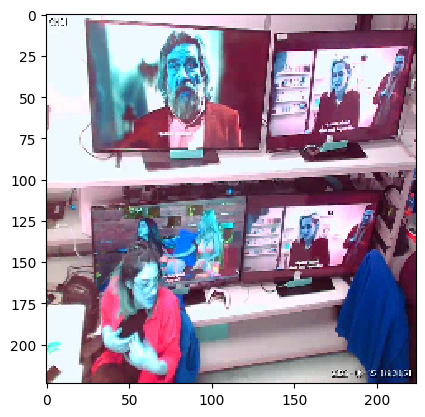

In [70]:
for t in tr:
    print(t[2].shape)
    plt.imshow(t[0][0][0], interpolation='nearest')
    plt.show()
    break

In [7]:
def calc_f1(pre, rec):
    return 2 * (pre * rec) / (pre + rec)

In [72]:
sota_cnn = InceptionV3(include_top=False)

In [73]:
inputs = keras.Input(shape=(time_dist, *input_shape), batch_size=batch_size, dtype=tf.uint8)

In [79]:
xx = TimeDistributed(sota_cnn)(inputs)
xx = TimeDistributed(Flatten())(xx)
xx = GRU(64, activation="softmax")(xx)
out = Dense(1, activation='softmax')(xx)

metamorph = tf.keras.Model(inputs, out)

for layer in sota_cnn.layers:
    layer.trainable = False

metamorph.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TruePositives(),
        "accuracy"
    ]
)

In [80]:
metamorph.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(4, 250, 224, 224, 3)]   0         
                                                                 
 time_distributed_16 (TimeDi  (4, 250, 5, 5, 2048)     21802784  
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (4, 250, 51200)          0         
 stributed)                                                      
                                                                 
 gru_8 (GRU)                 (4, 64)                   9843072   
                                                                 
 dense_8 (Dense)             (4, 1)                    65        
                                                                 
Total params: 31,645,921
Trainable params: 9,843,137
Non-tr

In [ ]:
shuffled = np.asarray(sorted(list(os.walk(org_path / class_paths[0] / "Train"))[0][2], key=lambda x: len(x)))

sample_weights = []
for i in range(32, len(shuffled)):
    temp_w = []

    if os.path.isfile(org_path / class_paths[0] / "Train" / "Label" / shuffled[i]):
        temp_w.append(both_weight)
    elif os.path.isfile(org_path / class_paths[0] / "Train" / "Label" / ins_ind(shuffled[i], 'l', shuffled[i].index('.'))):
        temp_w.append(lie_weight)
    elif os.path.isfile(org_path / class_paths[0] / "Train" / "Label" / ins_ind(shuffled[i], 'e', shuffled[i].index('.'))):
        temp_w.append(err_weight)
    else:
        temp_w.append(none_weight)

    sample_weights.append(temp_w)
    temp_w = []

sample_weights

In [81]:
history1 = metamorph.fit(
    tr.repeat(),
    epochs=2,
    steps_per_epoch=len(list(os.walk(org_path / class_paths[0] / "Train"))[0][2]) // batch_size,
    # validation_steps=len(list(os.walk(org_path / class_paths[0] / "Val"))[0][2]) // batch_size,
    # validation_data=val.repeat()
)

Epoch 1/2


ValueError: in user code:

    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "c:\Users\SWQA\miniconda3\envs\tf-directml38\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(8,) and logits.shape=(4, 1)


In [91]:
for layer in metamorph.layers[:25]:
   layer.trainable = False
for layer in metamorph.layers[25:]:
   layer.trainable = True
   
from tensorflow.keras.optimizers import SGD
metamorph.compile(
   optimizer=SGD(lr=0.0001, momentum=0.9),
   loss='binary_crossentropy',
   metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.F1Score(),
        "accuracy"
   ]
)

In [161]:
(xtr, ytr), (xte, yte) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [164]:
xtr[1:].shape

(59999, 28, 28)

In [ ]:
history2 = metamorph.fit(
    tr.repeat(),
    epochs=25,
    batch_size=batch_size,
    steps_per_epoch=len(list(os.walk(org_path / class_paths[0] / "Train"))[0][2]) // batch_size,
    validation_steps=len(list(os.walk(org_path / class_paths[0] / "Val"))[0][2]) // batch_size,
    validation_data=val.repeat()
)

In [289]:
signature = (tf.TensorSpec(shape=(None, *input_shape), dtype=tf.uint8),
                 tf.TensorSpec(shape=(None, 1), dtype=tf.uint8))

train_dataset2 = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", class_paths[1]),
            output_signature=signature
        )

(224, 224, 3)


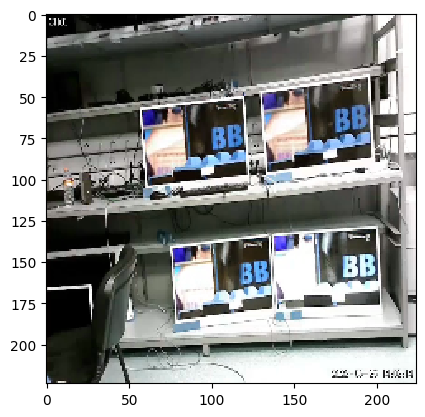

In [291]:
for tt in train_dataset2:
    print(tt[0][1].shape)
    plt.imshow(tt[0][1], interpolation='nearest')
    plt.show()
    break

In [288]:
metamorph.evaluate(
    te.repeat(),
    steps=len(list(os.walk(org_path / class_paths[0] / "Test"))[0][2]) // batch_size
)

193/193 [==============================] - 181s 916ms/step - loss: 7.3504e-04 - mean_squared_error: 1.6529e-04 - root_mean_squared_error: 0.0129 - false_negatives_7: 0.0000e+00 - true_negatives_7: 1142.0000 - false_positives_7: 1.0000 - true_positives_7: 5033.0000 - accuracy: 0.9998


[0.000735042616724968,
 0.00016529230924788862,
 0.012856605462729931,
 0.0,
 1142.0,
 1.0,
 5033.0,
 0.9998380541801453]

In [179]:
calc_f1(0.9561, 0.9509)

0.9534929103303618

In [ ]:
W1

false_negatives 0.0
true_negatives  1142.0
false_positives 1.0
true_positives  5033.0

In [ ]:
W0

false_negatives 0.0
true_negatives  1140.0
false_positives 3.0
true_positives  5033.0

In [322]:
signature = (tf.TensorSpec(shape=(None, *input_shape), dtype=tf.uint8),
                 tf.TensorSpec(shape=(None, 1), dtype=tf.uint8))

train_dataset3 = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", class_paths[2]),
            output_signature=signature
        )

In [323]:
metamorph.evaluate(
    train_dataset3.repeat(),
    steps=len(list(os.walk(org_path / class_paths[2] / "Train"))[0][2]) // batch_size
)

293/293 [==============================] - 244s 831ms/step - loss: 0.0706 - mean_squared_error: 0.0113 - root_mean_squared_error: 0.1061 - false_negatives_7: 9.0000 - true_negatives_7: 9058.0000 - false_positives_7: 105.0000 - true_positives_7: 204.0000 - accuracy: 0.9878


[0.07059326767921448,
 0.011258484795689583,
 0.10610600560903549,
 9.0,
 9058.0,
 105.0,
 204.0,
 0.9878413081169128]

In [ ]:
false_negatives 9.0
true_negatives  9058.0
false_positives 105.0
true_positives  204.0